# Table of Content
- Imports
- Load Data
- Dataset Overview
- Visualization

# Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cufflinks as cl
import os
%matplotlib inline

# Load Data

In [3]:
file_path = os.path.join('data', 'ks-projects-201612.csv')
df = pd.read_csv(file_path, encoding="ISO-8859-1")

C:\Users\Laurent\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning:

Columns (13,14,15) have mixed types. Specify dtype option on import or set low_memory=False.



# Dataset Overview

In [4]:
display(df.head())
display(df.info())
display(df.describe())

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09 11:36:00,1000,2015-08-11 12:12:28,0,failed,0,GB,0,NaN,NaN,NaN,NaN
1,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26 00:20:50,45000,2013-01-12 00:20:50,220,failed,3,US,220,NaN,NaN,NaN,NaN
2,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16 04:24:11,5000,2012-03-17 03:24:11,1,failed,1,US,1,NaN,NaN,NaN,NaN
3,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29 01:00:00,19500,2015-07-04 08:35:03,1283,canceled,14,US,1283,NaN,NaN,NaN,NaN
4,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01 13:38:27,50000,2016-02-26 13:38:27,52375,successful,224,US,52375,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 323750 entries, 0 to 323749
Data columns (total 17 columns):
ID                323750 non-null int64
name              323746 non-null object
category          323745 non-null object
main_category     323750 non-null object
currency          323750 non-null object
deadline          323750 non-null object
goal              323750 non-null object
launched          323750 non-null object
pledged           323750 non-null object
state             323750 non-null object
backers           323750 non-null object
country           323750 non-null object
usd pledged       319960 non-null object
Unnamed: 13       625 non-null object
Unnamed: 14       12 non-null object
Unnamed: 15       4 non-null object
Unnamed: 16       1 non-null float64
dtypes: float64(1), int64(1), object(15)
memory usage: 42.0+ MB


None

,ID,Unnamed: 16
count,3.237500e+05,1.0
mean,1.074943e+09,25.0
std,6.193352e+08,NaN
min,5.971000e+03,25.0
25%,5.375802e+08,25.0
50%,1.075818e+09,25.0
75%,1.611070e+09,25.0
max,2.147476e+09,25.0


In [5]:
df.columns

Index(['ID ', 'name ', 'category ', 'main_category ', 'currency ', 'deadline ',
       'goal ', 'launched ', 'pledged ', 'state ', 'backers ', 'country ',
       'usd pledged ', 'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15',
       'Unnamed: 16'],
      dtype='object')

#### Observations
    - Unnamed: 13, 14, 15, 16 are all blank when opened with Notepad++ and Microsoft Excel. The 2018 version of the dataset
      has 3 additional columns representing a country and how much it pledged. These columns may have been 
      accidentally picked up using ISO-8859-1 encoding when loading the data
    - Based on the values observation the goal should be a numeric column but the actual values are of different currency.
    - All column names have white space at the end.

In [81]:
display(df[df['backers '].str.isnumeric() == False][['backers ', 'state ', 'pledged ', 'launched ']].head())
print("Number of observation that aren't numeric:", df[df['backers '].str.isnumeric() == False]['backers '].count())

print("Number of unique observations that aren't numeric:", 
      df[df['backers '].str.isnumeric() == False]['backers '].nunique(), '\n')

print("Unique Observations that aren't numeric:\n", 
      df[df['backers '].str.isnumeric() == False]['backers '].unique())

,backers,state,pledged,launched
1454,failed,4262,2016-01-03 00:56:46,15000
1563,failed,3984,2014-08-09 03:16:02,13730
1794,failed,525,2011-11-21 23:25:46,5000
1931,failed,0,2014-08-21 19:56:10,6300
2420,successful,3035,2013-02-25 21:11:57,3000


Number of observation that aren't numeric: 624
Number of unique observations that aren't numeric: 9 

Unique Observations that aren't numeric:
 ['failed' 'successful' 'canceled' 'live' 'undefined' '2012-06-06 23:54:14'
 '2015-07-03 18:23:23' '2014-02-05 02:06:20' '88619.2']


#### Observations
    - the majority of project are funded by USA Dollars
    - There seems to be a mistake in the dataset. Whenever a backers string observation is not potentially numeric it has a 
      the status of the kickstarter which are the values of the "state " feature. Certain observations seems to be shifted 
      to the next column

In [82]:
print('Total number of projects:', df.shape[0])
print('Number of projects in 2007:', df[df['launched '].str.contains(pat = '2007-')]['launched '].count())
print('Number of projects in 2008:', df[df['launched '].str.contains(pat = '2008-')]['launched '].count())
print('Number of projects in 2009:', df[df['launched '].str.contains(pat = '2009-')]['launched '].count())
print('Number of projects in 2010:', df[df['launched '].str.contains(pat = '2010-')]['launched '].count())
print('Number of projects in 2011:', df[df['launched '].str.contains(pat = '2011-')]['launched '].count())
print('Number of projects in 2012:', df[df['launched '].str.contains(pat = '2012-')]['launched '].count())
print('Number of projects in 2013:', df[df['launched '].str.contains(pat = '2013-')]['launched '].count())
print('Number of projects in 2014:', df[df['launched '].str.contains(pat = '2014-')]['launched '].count())
print('Number of projects in 2015:', df[df['launched '].str.contains(pat = '2015-')]['launched '].count())
print('Number of projects in 2016:', df[df['launched '].str.contains(pat = '2016-')]['launched '].count())

Total number of projects: 323750
Number of projects in 2007: 0
Number of projects in 2008: 0
Number of projects in 2009: 1324
Number of projects in 2010: 10491
Number of projects in 2011: 26175
Number of projects in 2012: 41090
Number of projects in 2013: 44756
Number of projects in 2014: 67602
Number of projects in 2015: 77182
Number of projects in 2016: 54499


# Visualization

Number of unique categories: 770
Number of categories in top 10 percent: 77


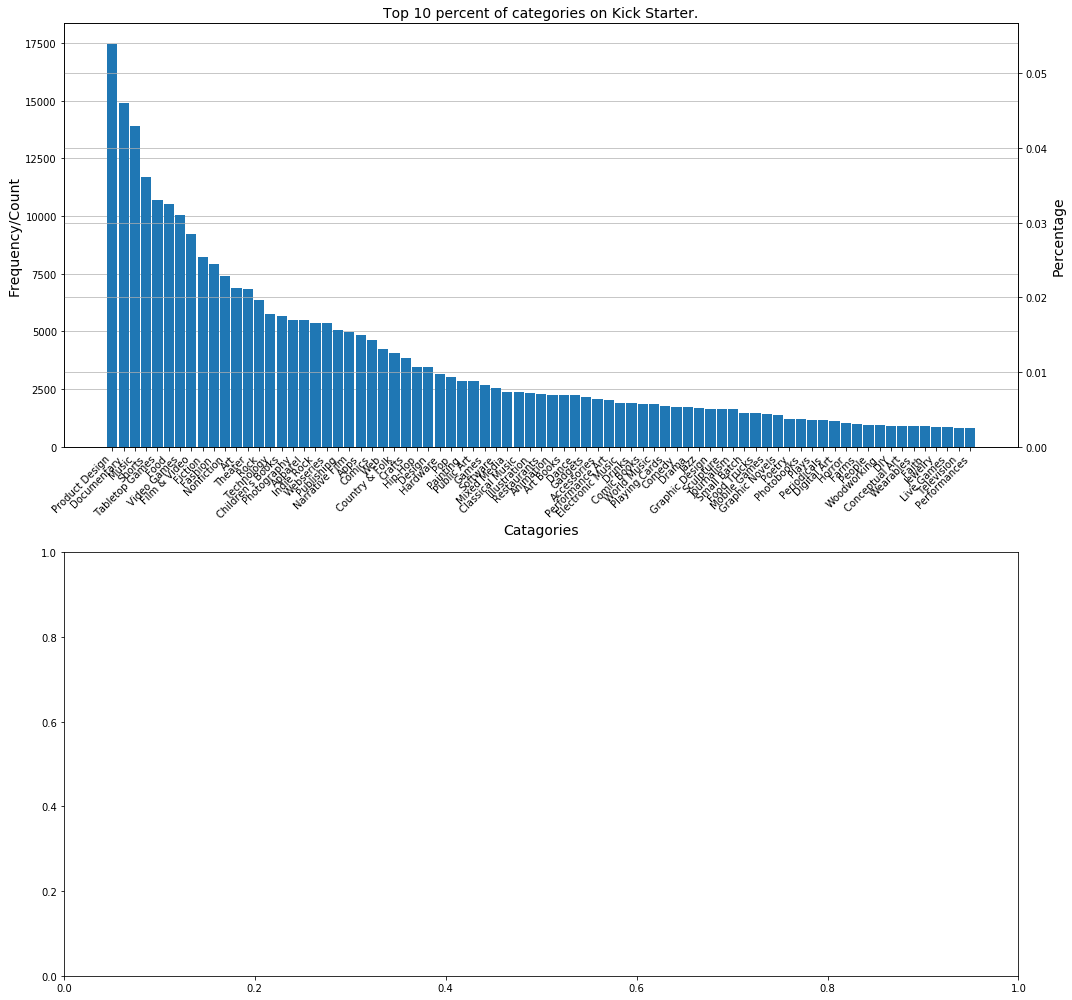

In [40]:
#Declaration
fig, ax = plt.subplots(nrows=2, figsize=(15,14))
length = df['category '].value_counts().size
percent = 10/100
x = df['category '].value_counts().index[:int(length*percent)]


print("Number of unique categories:", df['category '].nunique())
print("Number of categories in top 10 percent:", int(length*percent))


y = df['category '].value_counts()[:int(length*percent)]
ax[0].set_title("Top 10 percent of categories on Kick Starter.", fontsize=14)
ax[0].set_xlabel("Catagories", fontsize=14)
ax[0].set_ylabel("Frequency/Count", fontsize=14)
ax[0].bar(x=x, height=y, width=0.9)
ax[0].yaxis.grid(linestyle='-', linewidth=0.7)
ax[0].set_xticklabels(x, rotation=45, ha='right')

y = df['category '].value_counts(normalize=True)[:int(length*percent)]
ax[1] = ax[0].twinx()
ax[1].set_ylabel("Percentage", fontsize=14)
ax[1].yaxis.grid(linestyle='-', linewidth=0.7)

"""y = df['category '].value_counts(normalize=True)[:int(length*percent)]
ax[1].set_title("Top 10 percent of categories on Kick Starter.", fontsize=14)
ax[1].set_xlabel("Catagories", fontsize=14)
ax[1].set_ylabel("Percentage", fontsize=14)
ax[1].bar(x=x, height=y, width=0.9)
ax[1].yaxis.grid(linestyle='-', linewidth=0.7)
ax[1].set_xticklabels(x, rotation=45, ha='right')"""

plt.tight_layout();

Number of unique main categories: 120


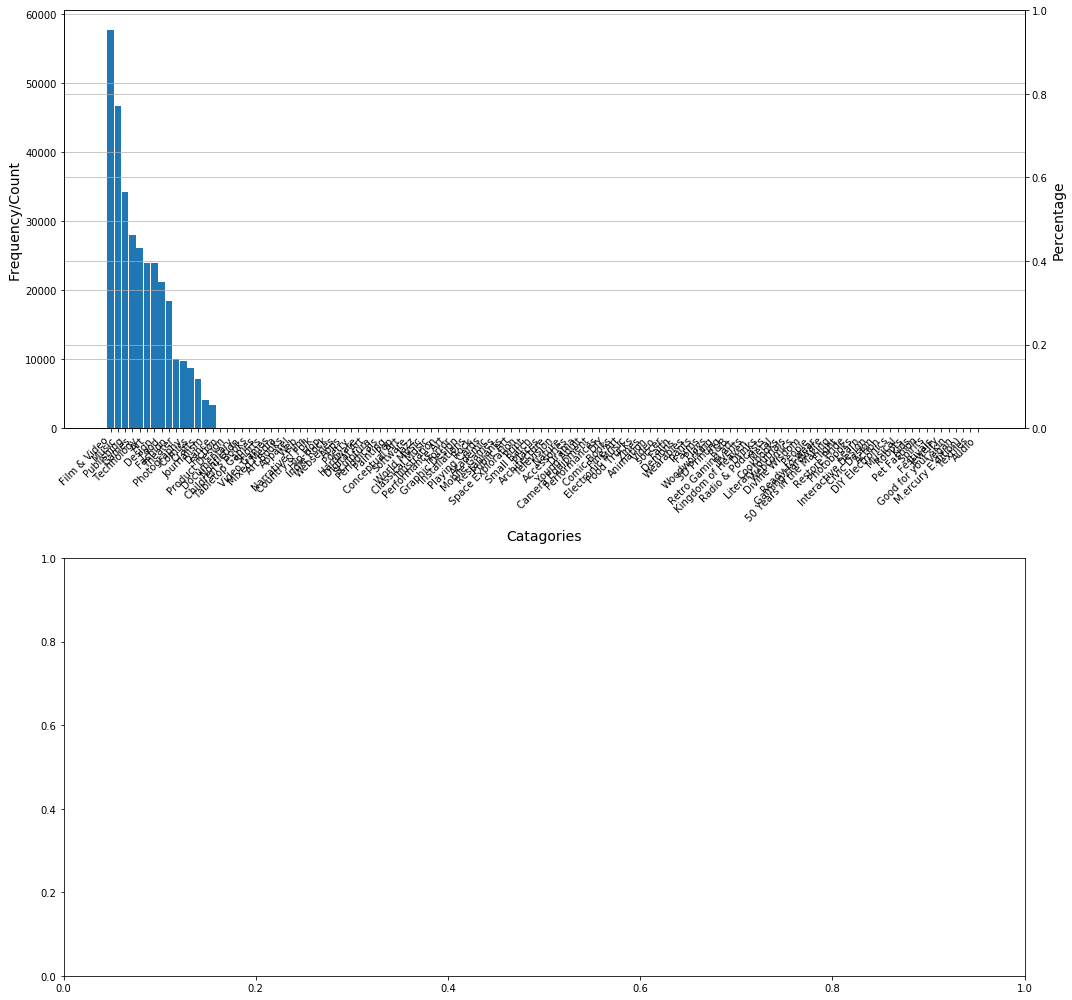

In [43]:
#Declaration
fig, ax = plt.subplots(nrows=2, figsize=(15,14))
x = df['main_category '].value_counts().index[:int(length*percent)]


print("Number of unique main categories:", df['main_category '].nunique())

y = df['main_category '].value_counts()
ax[0].set_xlabel("Catagories", fontsize=14)
ax[0].set_ylabel("Frequency/Count", fontsize=14)
ax[0].bar(x=x, height=y, width=0.9)
ax[0].yaxis.grid(linestyle='-', linewidth=0.7)
ax[0].set_xticklabels(x, rotation=45, ha='right')

y = df['main_category '].value_counts(normalize=True)
ax[1] = ax[0].twinx()
ax[1].set_ylabel("Percentage", fontsize=14)
ax[1].yaxis.grid(linestyle='-', linewidth=0.7)


'''
y = df['main_category '].value_counts(normalize=True)[:int(length*percent)]
ax[1].set_xlabel("Catagories", fontsize=14)
ax[1].set_ylabel("Percentage", fontsize=14)
ax[1].bar(x=x, height=y, width=0.9)
ax[1].yaxis.grid(linestyle='-', linewidth=0.7)
ax[1].set_xticklabels(x, rotation=45, ha='right')'''

plt.tight_layout();

#### Observations
    - the majority of catagories were not recorded to generalize. Instead they appear to represent very specific 
      products/ideas/events only appearing 1 time in the entire dataset.
    - Main catagory has 120 unique values. This is ~ 1/7 of the "catagory " unique values. This may be a better 
      representation of what the kick starter project catagorizes as.

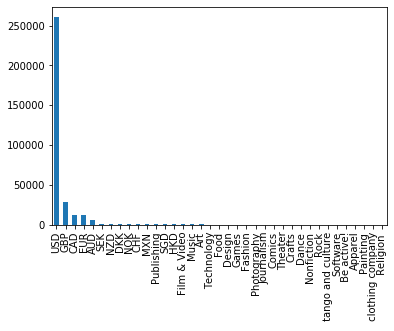

In [84]:
df['currency '].value_counts().plot('bar');

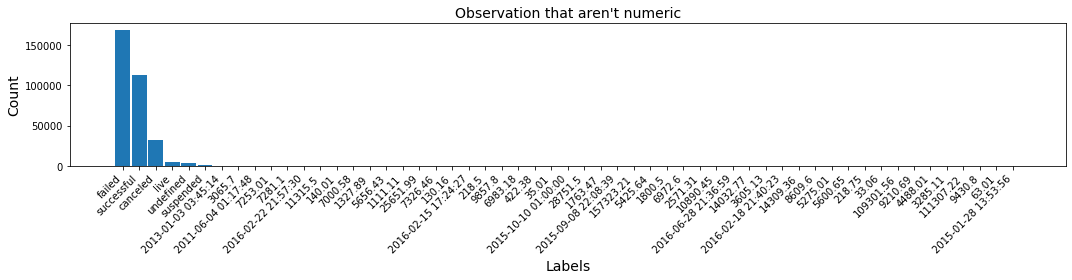

In [99]:
fig, ax = plt.subplots(figsize=(15,4))
x = df[df['state '].str.isnumeric() == False]['state '].value_counts().index
y = df[df['state '].str.isnumeric() == False]['state '].value_counts()

ax.bar(x=x, height=y, width=0.9)
ax.set_xticklabels(x, rotation=45, ha='right')
ax.set_title("Observation that aren't numeric", fontsize=14)
ax.set_ylabel("Count", fontsize=14)
ax.set_xlabel("Labels", fontsize=14)
plt.tight_layout();

#### Observations
    - It seems the shifting of data is with multiple columns as the a few unique dates and currency are apart of the 
    "state " column.


In [14]:
#plt.gca().yaxis.grid(True)
#plt.xticks(rotation=45, ha='right');